The average refractive index is:  1.9


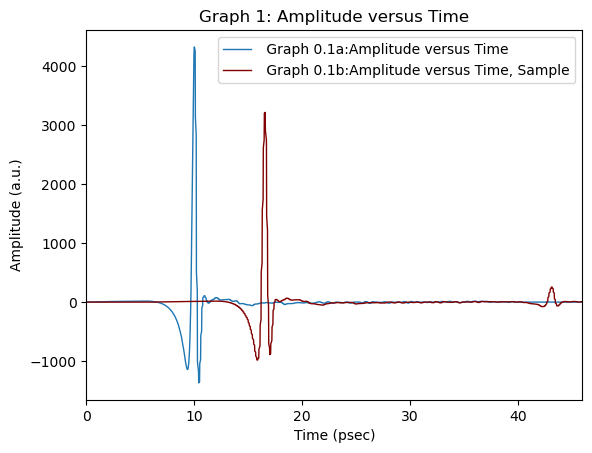

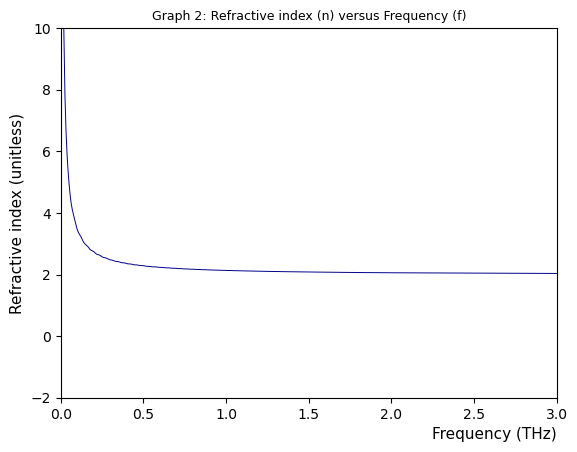

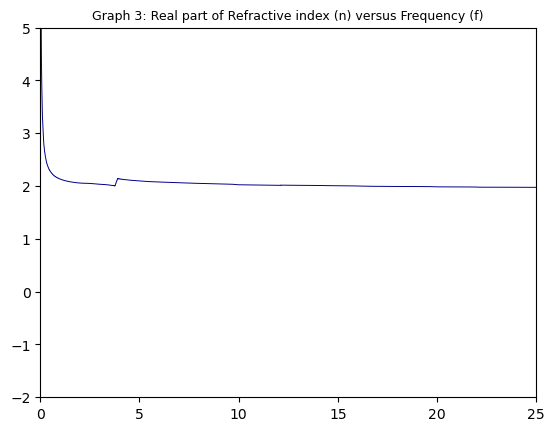

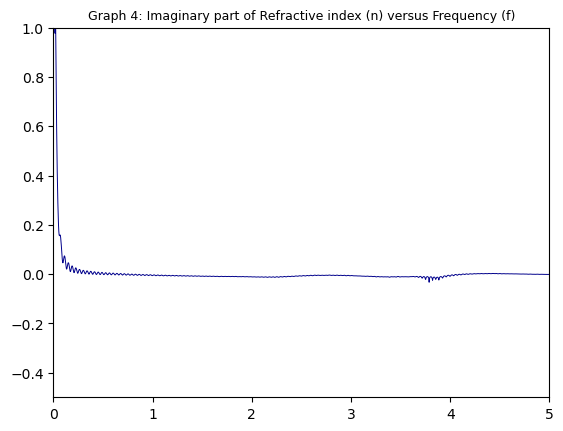

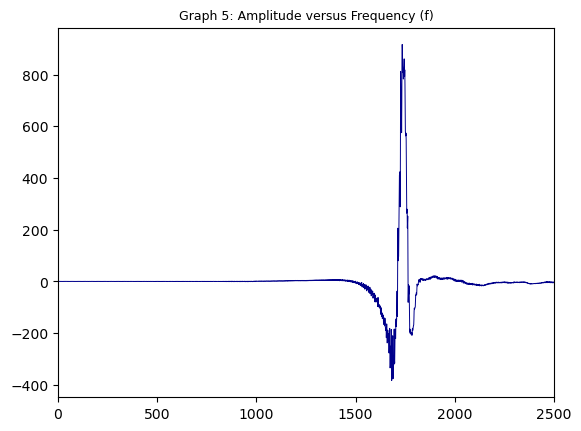

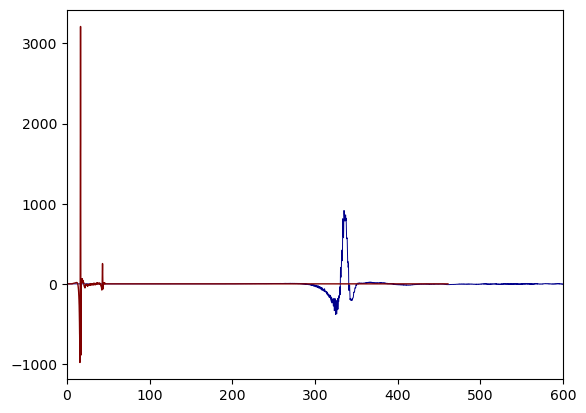

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.signal

# INSERT DATA 
data1 = np.loadtxt("AmpTimeRef.txt",dtype=float)
data2 = np.loadtxt("AmpTimeSample.txt",dtype=float)


t1= data1[:,0] 
y1 = data1[:,1]
t2 = data2[:,0] 
y2 = data2[:,1]

# INTERPOLATION
startt = 0
endt = 46.1 * 1e-11
dt = min(np.mean(np.diff(t2)), np.mean(np.diff(t1)))
t = np.arange(startt, endt + dt, dt)

sr = np.interp(t, t1, y1, left=0, right=0)
ss = np.interp(t, t2, y2, left=0, right=0)

# FFTS
fftr = np.fft.fft(sr, 16384)
ffts = np.fft.fft(ss, 16384)
freq = np.fft.fftfreq(16384, dt) #time to frequency


# MASKING THE NEGATIVE FREQUENCIES
mask = (freq >= 0) 
fftr = fftr[mask]
ffts = ffts[mask]
freq = freq[mask]

freq[freq == 0] = 1e-12  # Replace zeros with a small value to avoid division by zero

# TRANSFER FUNCTION
tamp = (ffts / fftr)
ln_exp = np.log(np.abs(tamp))
tphase = np.angle(tamp)

# PHASE
tphase_unwrapped = np.unwrap(tphase)
#tphase_unwrapped -= tphase_unwrapped[0]-0.5*np.pi

uwr = np.unwrap(np.angle(fftr))
uws= np.unwrap(np.angle(ffts))
delta = uws - uwr

# REFRACTIVE INDEX THEORETICAL
dt =  6* 1e-12 #seconds
c = 3e8 #speed of light in m/s
d = 2e-3 #thickness of sample in m
n_0 = 1  # Refractive index of air

navg = 1 + (c * dt) / d
print("The average refractive index is: ", navg)

n = 1 + (np.abs(delta)* c) / (2 * np.pi * freq  * d)

#NEWTON RAPHSON METHOD
def G_zero(n, f, ln_exp):

    ln_th =(np.log((4 * n_0 * n) / (n_0 + n)**2)
             -(1j * 2 * np.pi * f * d / c) * (n - n_0))
    return  ln_th - ln_exp

def G_zerod(n, f):
    p = 1 / n
    m = 2 / (n + n_0) + (1j * 2 * np.pi* f * d) / c 
    return p - m 

def new_raph(n_1, ln_exp, f, iterations, tol):
    n = n_1
    for i in range(iterations): 
        G_zero_ = G_zero(n,  f, ln_exp)
        G_zerod_ = G_zerod(n, f)
        dn = G_zero_ / G_zerod_
        n = n - dn
        if abs(G_zero_/G_zerod_) < tol:
           # print(i, "iterations")
            break
    return n


# INITIAL GUESS AND CALCULATION
n_1 = 1.8 + 0.05j
n_ = []

for i, f in enumerate(freq, 0):
    ln_exp = np.log(np.abs(tamp[i])) + 1j * tphase_unwrapped[i]
    n_values = new_raph( n_1 ,ln_exp, f,  iterations=50, tol=1e-10)
    n_.append(n_values)


# print("Refractive index values:", n_)
n_ = np.array(n_)



# MAKING THE INVERSE FOURIER TRANSFORM 

#FIRST METHOD / INVERSE FOURIER 

ln_theoretical =np.log((4 * n_0 * n_) / (n_0 + n_)**2) -(1j * 2 * np.pi * freq * d / c) * (n_ - n_0)
amp_theoretical = np.exp(ln_theoretical)
amp_s = amp_theoretical * ffts
inverse = np.fft.ifft(amp_s, 23856)



# PLOTTING

# AMPLITUDE VERSUS TIME
plt.xscale("linear")
plt.yscale("linear")
plt.xlabel("Time (psec)")
plt.ylabel("Amplitude (a.u.)")
plt.title("Graph 1: Amplitude versus Time")
plt.plot(t *1e12  ,sr, linewidth = 1)
plt.plot(t *1e12, ss, color = "maroon",  linewidth = 1)
plt.legend([" Graph 0.1a:Amplitude versus Time", " Graph 0.1b:Amplitude versus Time, Sample"])
plt.xlim(xmax = 46, xmin = 0)
plt.show()

# THEORETICAL REFRACTIVE INDEX
plt.plot( freq * 1e-12, n , color = "darkblue", linewidth = 0.7)
plt.title("Graph 2: Refractive index (n) versus Frequency (f)", fontsize = 9)         
plt.xlabel("Frequency (THz)", fontsize = 11, loc = "right")
plt.ylabel("Refractive index (unitless)", fontsize = 11)  
plt.xscale("linear")
plt.yscale("linear")  
plt.xlim(xmax = 3, xmin = 0 )
plt.ylim(ymax = 10, ymin = -2)
plt.show()


# REFRACTIVE INDEX REAL PART
plt.title("Graph 3: Real part of Refractive index (n) versus Frequency (f)", fontsize = 9)
plt.plot ( freq *1e-12 , np.real(n_), linewidth=0.7, color='darkblue')
plt.xlim(xmax = 25, xmin = 0)
plt.ylim(ymax = 5, ymin = -2)
plt.show()

# REFRACTIVE INDEX IMAGINARY PART
plt.title("Graph 4: Imaginary part of Refractive index (n) versus Frequency (f)", fontsize = 9)
plt.plot ( freq *1e-12 , np.imag(n_), linewidth=0.7, color='darkblue')
plt.xlim(xmax = 5, xmin = 0)
plt.ylim(ymax = 1, ymin = -0.5)
plt.show()


# AMPLITUDE VERSUS FREQUENCY THEORETICAL COMPUTATION
plt.title("Graph 5: Amplitude versus Frequency (f)", fontsize = 9)
plt.plot( inverse,  color = "darkblue", linewidth = 0.7)
#plt.plot(t *1e12, ss, color = "maroon",  linewidth = 1)
plt.xlim(xmax = 2500, xmin = 0)
plt.show()


# TRY TO PLOT THE SIGNALS TO SEE HOW CLOSE WE ARE
plt.plot(t*10e12, inverse.real, color = "darkblue", linewidth = 0.7)
plt.plot(t *1e12, ss, color = "maroon",  linewidth = 1)
plt.xlim(xmax = 600, xmin = 0)

plt.show()